<a href="https://colab.research.google.com/github/elainedias16/TCC/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BBC News Dataset

# Reading the Dataset and Creating the Dataframe

In [1]:
import pandas as pd

id_file = '1m41gWGwnLYo0nAEOABnU_MH_SCQHWfjS'
url_file = 'https://drive.google.com/uc?id={}'.format(id_file)

def create_dataframe(path):
    columns=['genre', 'filename', 'title', 'content']
    df =  pd.read_table(
    path,
    header=None,
    names=columns,
    sep= '\t',
    engine= 'python'
    )
    return df


df = create_dataframe(url_file)
df = df.drop(0).reset_index(drop=True)

df.tail()

,genre,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


In [2]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import spacy
from spacy.lang.en.examples import sentences

!pip install unidecode
import unidecode
from nltk.stem.porter import PorterStemmer
!python -m spacy download en_core_web_sm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Rename filenames

In [3]:
# In BBC dataset, some filenames have the same name, for example 001.txt, so it's necessary to rename
def rename_filenames(df):
  for index, row in df.iterrows():
      df.at[index, 'filename'] = f"{index}.txt"
  return df

df = rename_filenames(df)

## Create dataset with less samples

In [4]:
import random

# def create_balanced_small_df(df, genres, num):
#   small_df_list = []
#   for genre in genres:
#     sample_rows = df.sample(num)
#     small_df_list.append(sample_rows)
#   return pd.concat(small_df_list).reset_index(drop=True)

def create_imbalanced_small_df(df, genres, max_value):
  small_df_list = []
  for genre in genres:
    qtd = random.randint(1, max_value)
    # print(qtd)
    sample_rows = df[df['genre'] == genre].sample(qtd)
    small_df_list.append(sample_rows)
  return pd.concat(small_df_list).reset_index(drop=True)


In [5]:
genres = df['genre'].unique()
small_df = create_imbalanced_small_df(df, genres, max_value=15)
small_df

,genre,filename,title,content
0,business,487.txt,US budget deficit to reach $368bn,The US budget deficit is set to hit a worse-t...
1,business,472.txt,Two Nigerian banks set to merge,Nigerian banks United Bank of Africa and Stan...
2,business,398.txt,Indian oil firm eyes Yukos assets,"India's biggest oil exploration firm, Oil & N..."
3,entertainment,726.txt,Baywatch dubbed 'worst TV import',Surf show Baywatch has won the title of worst...
4,entertainment,776.txt,T in the Park sells out in days,Tickets for Scotland's biggest music festival...
5,politics,1168.txt,'Best person' for top legal job,"The ""best person for the job"" should be appoi..."
6,politics,978.txt,Hague 'given up' his PM ambition,Former Conservative leader William Hague says...
7,sport,1641.txt,"Umaga ready for ""fearsome"" Lions",All Blacks captain Tama Umaga has warned the ...
8,sport,1786.txt,Mauresmo opens with victory in LA,Amelie Mauresmo and Maria Sharapova won their...
9,sport,1821.txt,Melzer shocks Agassi in San Jose,Second seed Andre Agassi suffered a comprehen...


# Pre Processing

In [6]:
def remove_non_alphanumeric(text):
    words = ''
    for w in text:
        words += w if w.isalnum() else ' '
    return words

def remove_accents(text):
  return unidecode.unidecode(text)


def lowercasting(tokens):
  tokens = [w.lower() for w in tokens]
  return tokens

def remove_stop_words(tokens):
  stop_words = set(stopwords.words('english')) #List of stop words in english
  tokens = [token for token in tokens if token not in stop_words]
  return tokens


def stemming(tokens):
  porter = PorterStemmer()
  tokens = [porter.stem(token) for token in tokens]
  return tokens


def lemmanization(text):
    nlp = spacy.load("en_core_web_sm")    # Load English language model
    doc = nlp(text)   # Process the text using the Spacy NLP
    tokens = [token.lemma_ for token in doc]
    return tokens


def pre_processing_aux(text):
  words = remove_non_alphanumeric(text)
  words = remove_accents(words)
  tokens = word_tokenize(words)
  tokens = lowercasting(tokens)
  tokens = remove_stop_words(tokens)
  words = ' '.join(tokens)
  tokens = lemmanization(words)
  tokens = stemming(tokens)
  return ' '.join(tokens)


In [7]:
def pre_processing(df):
    df['content'] = df['content'].apply(pre_processing_aux)
    return df

###########################################################
# To prossegue with all dataset, put df on parameter
# To prossegue with small dataset, put small_df in paramter
############################################################

df = pre_processing(small_df)
df.tail()

,genre,filename,title,content
21,tech,1928.txt,Nuclear body seeks new tech,comput system use monitor world nuclear power ...
22,tech,1840.txt,Finding new homes for old phones,use old mobil phone good environ social benefi...
23,tech,2029.txt,Row brewing over peer-to-peer ads,music download network prove popular audienc y...
24,tech,2189.txt,Rolling out next generation's net,bodi overse net work grow evolv say cope well ...
25,tech,1987.txt,Who do you think you are?,real danger happen data cross net argu analyst...


# Basic statistics analysis

##Documents number by class

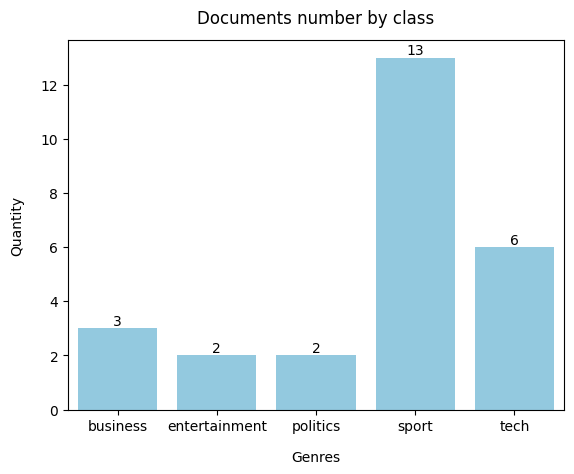

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

genres = df['genre'].unique()

def plot_doc_by_class(genres):
  ax = sns.countplot(x = 'genre', data = df , color='skyblue')
  ax.yaxis.grid(False)
  plt.title('Documents number by class', pad=12)
  plt.xlabel('Genres', labelpad=12)
  plt.ylabel('Quantity', labelpad=12)

  bars = ax.patches
  # Put numbers of docs above bars
  for bar in bars:
        height = int(bar.get_height())
        plt.text(bar.get_x() + bar.get_width()/2, height, height, ha='center', va='bottom')

  plt.show()


plot_doc_by_class(genres)

#Top 30 most frequent words

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn

def get_genre_content(df, genre):
  content = df.loc[df['genre'] == genre, 'content'].str.cat(sep=' ')
  return content

def create_dict_content(df):
  dict_content = {}
  for genre in genres:
      dict_content[genre] = get_genre_content(df, genre)
      if 'all' in dict_content:
        dict_content['all'] += get_genre_content(df, genre)
      else:
          dict_content['all'] = get_genre_content(df, genre)
  return dict_content

def create_count_content(dict_content):
  count_content = {}
  for genre, content in dict_content.items():
      count_content[genre] = Counter(content.split())
  return count_content


def get_top_n_words(top_n, count_words):
    most_common_words = {}
    for word, count in count_words.most_common(top_n):
        most_common_words[word] = count
    return most_common_words


In [10]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_h_most_common_words(top_n, count_content, genre, title, fontsize):
    most_common = get_top_n_words(top_n, count_content[genre])
    most_common = sorted(most_common.items(), key=lambda x: x[1])
    words = [item[0] for item in most_common ]
    counts = [item[1] for item in most_common ]
    plt.figure(figsize=(11, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Quantity', labelpad=15)
    plt.ylabel('Tokens', labelpad=15)
    plt.grid(False)
    plt.title(title, pad=15)
    #Display number of token in front of each bar
    for i in range(len(words)):
      plt.text(counts[i], i, ' ' + str(counts[i]), ha='left', va='center')

dict_content = create_dict_content(df)
count_content = create_count_content(dict_content)

In [11]:
print(count_content)

{'business': Counter({'oil': 15, 'say': 14, 'year': 9, 'bank': 9, 'deficit': 8, 'ongc': 8, 'yuko': 8, 'india': 7, 'budget': 6, 'analyst': 6, 'unit': 6, 'standard': 6, 'trust': 6, 'presid': 5, 'russian': 5, 'product': 5, 'yugansk': 5, 'westwood': 5, 'us': 4, 'cost': 4, 'militari': 4, 'also': 4, 'state': 4, 'big': 4, 'own': 4, 'buy': 4, 'asset': 4, 'produc': 4, 'russia': 4, 'hit': 3, 'tuesday': 3, 'oper': 3, 'cbo': 3, 'forecast': 3, 'would': 3, 'fiscal': 3, 'recent': 3, 'month': 3, 'import': 3, 'figur': 3, 'declin': 3, 'investor': 3, 'we': 3, 'previou': 3, 'new': 3, '2': 3, 'plan': 3, 'tax': 3, 'nigerian': 3, 'firm': 3, 'crude': 3, 'indian': 3, 'mr': 3, 'countri': 3, 'bpd': 3, 'interest': 3, 'could': 2, 'shortfal': 2, 'dollar': 2, 'size': 2, 'export': 2, 'record': 2, 'drive': 2, 'help': 2, 'econom': 2, 'septemb': 2, '2004': 2, 'total': 2, 'howev': 2, '8': 2, 'iraq': 2, 'one': 2, 'within': 2, 'meet': 2, 'reduc': 2, 'charg': 2, 'administr': 2, 'africa': 2, 'merg': 2, 'nation': 2, 'includ':

##Top 30 most frequent tokens in business

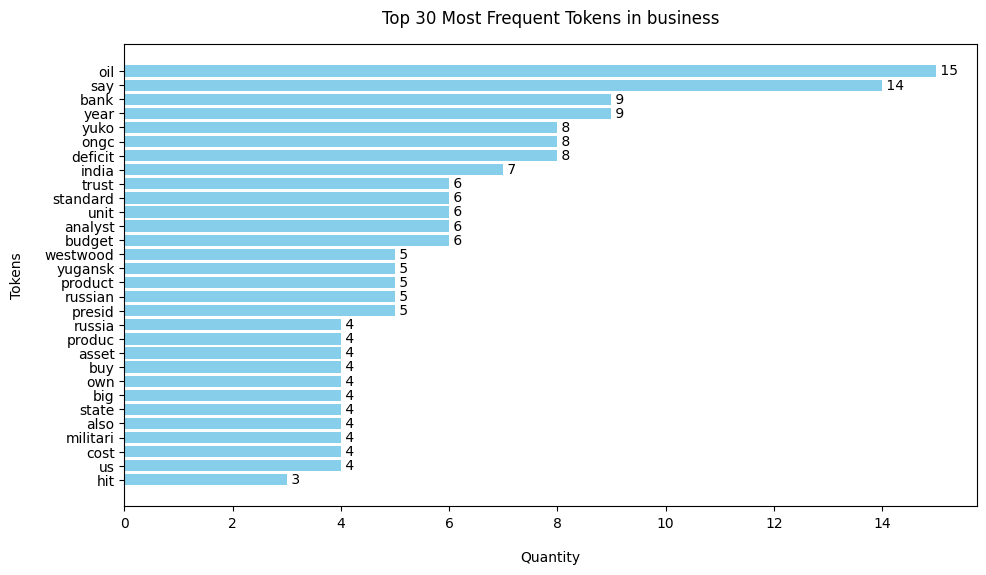

In [12]:
top_n = 30
fontsize = 12
title_business = 'Top {} Most Frequent Tokens in business'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'business', title_business, fontsize)
# common_words_business = get_top_n_words(top_n, count_content['business'])
# print(common_words_business)

##Top 30 most frequent tokens in entertainment




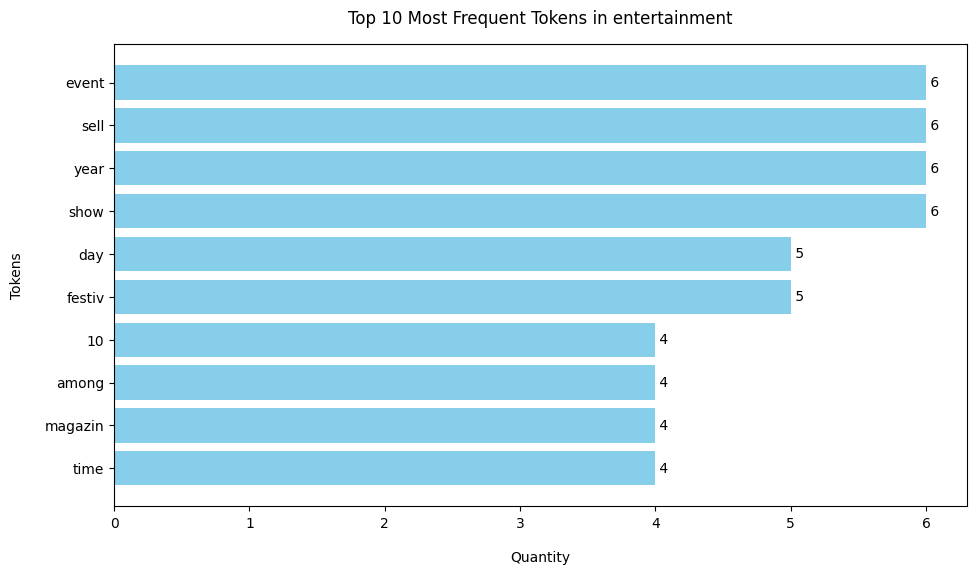

In [13]:
top_n = 10
fontsize = 12
title_entertainment = 'Top {} Most Frequent Tokens in entertainment'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'entertainment', title_entertainment, fontsize)
# common_words_entertainment = get_top_n_words(top_n, count_content['entertainment'])
# print(common_words_entertainment)

##Top 30 most frequent tokens in politics

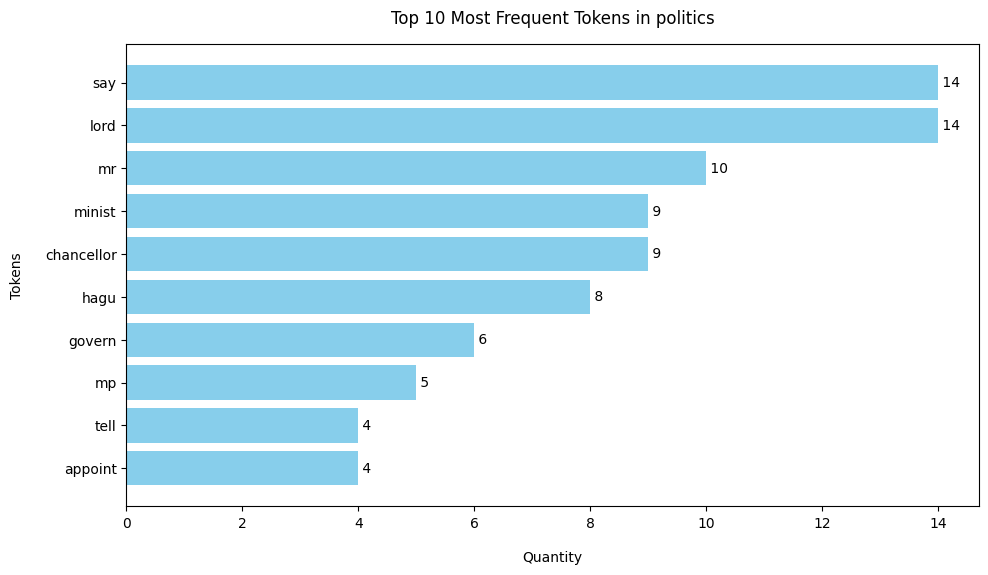

In [14]:
top_n = 10
fontsize = 12
title_politics = 'Top {} Most Frequent Tokens in politics'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'politics', title_politics, fontsize)
# common_words_politics = get_top_n_words(top_n, count_content['politics'])
# print(common_words_politics)

##Top 30 most frequent tokens in sport

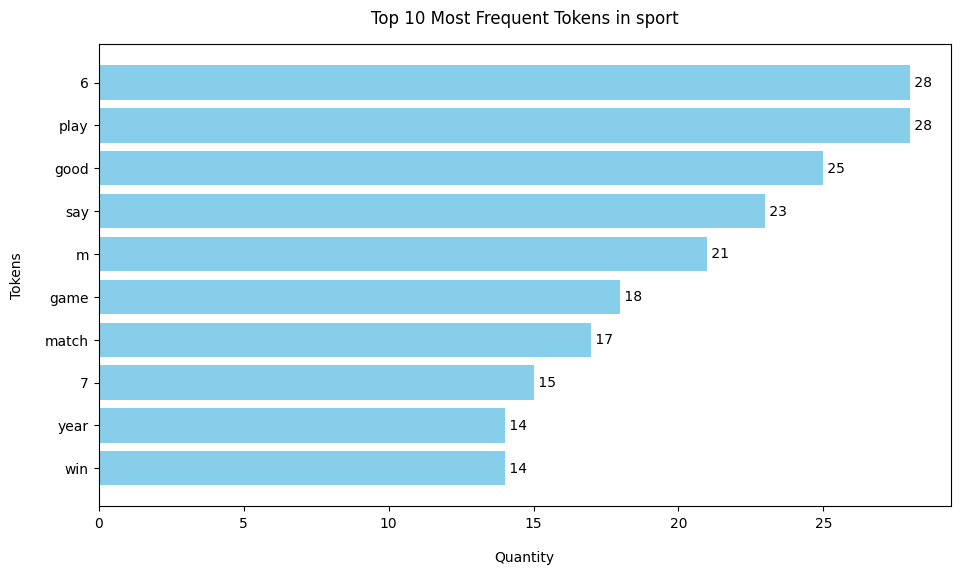

In [15]:
top_n = 10
fontsize = 12
title_sport = 'Top {} Most Frequent Tokens in sport'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'sport', title_sport, fontsize)
# common_words_sport = get_top_n_words(top_n, count_content['sport'])
# print(common_words_sport)

##Top 30 most frequent tokens in tech

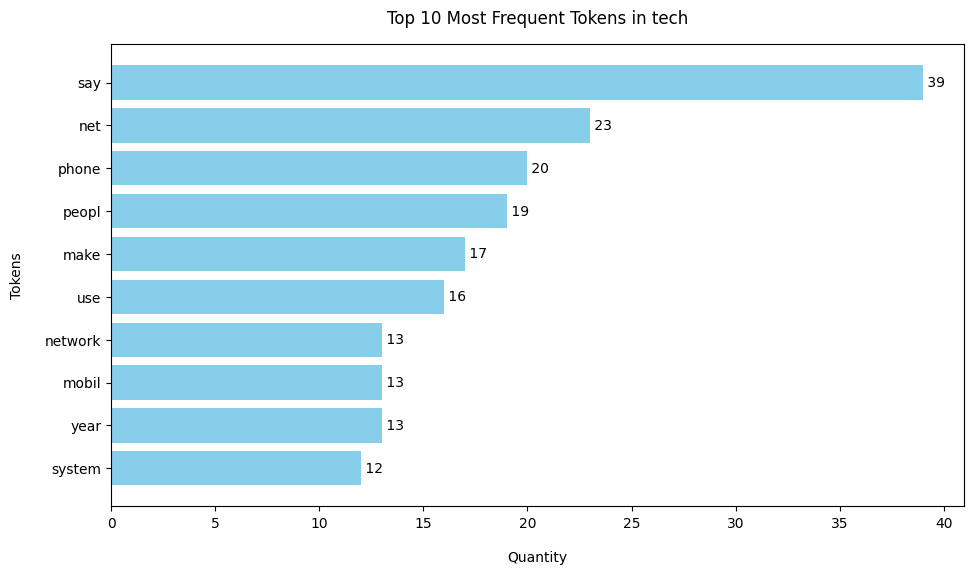

In [16]:
top_n = 10
fontsize = 12
title_tech = 'Top {} Most Frequent Tokens in tech'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'tech', title_tech, fontsize)
# common_words_tech = get_top_n_words(top_n, count_content['tech'])
# print(common_words_politics)

##Top 30 most frequent tokens in all dataset

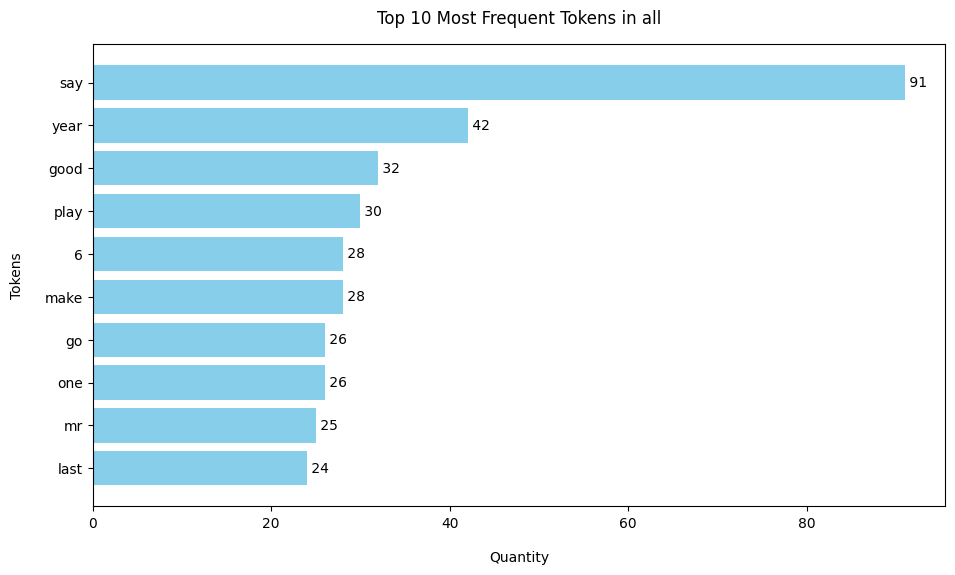

In [17]:
top_n = 10
fontsize = 12
title_all = 'Top {} Most Frequent Tokens in all'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'all', title_all, fontsize)
# common_words_all = get_top_n_words(top_n, count_content['all'])
# print(common_words_all)

#Frequency of class by word

In [18]:
import random

#Choose 10 random tokens in all content of news
random_words = random.sample(dict_content['all'].split(), 3)
print("random words: ", random_words)

def get_counts_by_genre(word, count_genres):
    counts_by_genre = {}  #Dictionary to store word count in each class
    for genre, content_counter in count_genres.items():
        if word in content_counter:
            counts_by_genre[genre] = content_counter[word]  # Adds the word count in the class to the dictionary
    return counts_by_genre


def get_frequency_class_by_word(selected_words, count_genres):
    dict_frequency = {}
    for word in selected_words:
        dict_frequency[word] = get_counts_by_genre(word, count_genres)
    return dict_frequency


dict_frequency = get_frequency_class_by_word(random_words, count_content)
print(dict_frequency)

random words:  ['time', 'sell', 'nevertheless']
{'time': {'business': 1, 'all': 21, 'entertainment': 4, 'politics': 1, 'sport': 11, 'tech': 4}, 'sell': {'business': 1, 'all': 8, 'entertainment': 6, 'sport': 1}, 'nevertheless': {'all': 1, 'sport': 1}}


In [19]:
#Testing
df[df['genre']=='politics']

,genre,filename,title,content
5,politics,1168.txt,'Best person' for top legal job,good person job appoint lord chancellor necess...
6,politics,978.txt,Hague 'given up' his PM ambition,former conserv leader william hagu say stand l...


# Frequency of words by documents

In [20]:
from collections import Counter

def get_frequency(df):
    frequency = {}
    for index, row in df.iterrows():
        filename = row['filename']
        word_counts = dict(Counter(row['content'].split()))
        if filename not in frequency:
          frequency[filename] = word_counts
    return frequency



frequency = get_frequency(df)
print(frequency)


{'487.txt': {'us': 3, 'budget': 6, 'deficit': 8, 'set': 1, 'hit': 2, 'bad': 1, 'expect': 1, '368bn': 1, '197bn': 1, 'year': 6, 'offici': 1, 'say': 5, 'tuesday': 2, 'cost': 4, 'militari': 4, 'oper': 3, 'still': 1, 'need': 1, 'factor': 1, 'analyst': 2, 'could': 2, 'end': 1, '100bn': 1, 'red': 1, 'past': 1, 'congression': 1, 'offic': 1, 'cbo': 3, 'forecast': 2, 'would': 1, '348bn': 1, 'shortfal': 2, '2005': 1, 'fiscal': 3, 'recent': 1, 'month': 2, 'dollar': 2, 'weaken': 1, 'amid': 1, 'market': 1, 'jitter': 1, 'size': 2, 'trade': 1, 'novemb': 1, 'gap': 1, 'export': 2, 'import': 1, 'widen': 1, '60bn': 1, 'record': 2, 'figur': 3, 'envisag': 1, 'orderli': 1, 'declin': 2, 'greenback': 1, 'next': 1, 'two': 1, 'twin': 1, 'drive': 1, 'investor': 1, 'away': 1, 'non': 1, 'partisan': 1, 'watchdog': 1, 'note': 1, 'help': 1, 'boost': 1, 'we': 1, 'econom': 2, 'growth': 1, '412bn': 1, '12': 1, '30': 1, 'septemb': 2, '2004': 1, 'reach': 1, '377bn': 1, 'previou': 3, 'also': 2, 'total': 1, '855bn': 1, '200

In [21]:
df[df['filename']=='253.txt']

,genre,filename,title,content


# Word Index by documents





In [22]:
def create_word_index(df):
    h = {}
    for index, row in df.iterrows():
        filename = row['filename']
        content = row['content']
        words = content.split()
        for word in words:
            if word not in h:
                h[word] = {}

            if filename not in h[word]:
                h[word][filename] = 1
            else:
                h[word][filename] += 1
    return h

word_index = create_word_index(df)
print(word_index)

{'us': {'487.txt': 3, '398.txt': 1, '1641.txt': 1, '1786.txt': 1, '1495.txt': 1, '1928.txt': 1, '1987.txt': 1}, 'budget': {'487.txt': 6}, 'deficit': {'487.txt': 8}, 'set': {'487.txt': 1, '1641.txt': 1, '1768.txt': 1, '1373.txt': 5}, 'hit': {'487.txt': 2, '398.txt': 1, '1641.txt': 1, '1539.txt': 1, '2025.txt': 1}, 'bad': {'487.txt': 1, '726.txt': 2, '1373.txt': 1, '1466.txt': 2, '2189.txt': 1}, 'expect': {'487.txt': 1, '776.txt': 1, '1495.txt': 1}, '368bn': {'487.txt': 1}, '197bn': {'487.txt': 1}, 'year': {'487.txt': 6, '398.txt': 3, '726.txt': 1, '776.txt': 5, '1641.txt': 2, '1786.txt': 1, '1495.txt': 2, '1659.txt': 1, '1584.txt': 1, '1539.txt': 2, '1768.txt': 1, '1373.txt': 3, '1466.txt': 1, '2025.txt': 2, '1928.txt': 3, '1840.txt': 3, '2189.txt': 4, '1987.txt': 1}, 'offici': {'487.txt': 1, '1928.txt': 1}, 'say': {'487.txt': 5, '472.txt': 1, '398.txt': 8, '726.txt': 1, '776.txt': 2, '1168.txt': 8, '978.txt': 6, '1641.txt': 2, '1786.txt': 4, '1821.txt': 3, '1495.txt': 1, '1659.txt': 1,

In [23]:
df[df['filename']=='253.txt']

,genre,filename,title,content


# Seach

## Pre processing in seach query

In [24]:
query = 'russian movie'
query = pre_processing_aux(query)
print(query)

russian movi


## Search query

In [25]:
def get_frequency_query(query, word_index):
    query_index = {}
    for word in query.split():
        if word in word_index:
            query_index[word] = word_index[word]
    return query_index


index_query = get_frequency_query(query, word_index)
print(index_query)


def sum_occurrences(index_query):
    f = {}
    for word_dict in index_query.values():
        for filename, count in word_dict.items():
            if filename not in f:
                f[filename] = count
            else:
                f[filename] += count

    return f

occurrences = sum_occurrences(index_query)
print(occurrences)

{'russian': {'398.txt': 5, '1786.txt': 2, '1768.txt': 1}}
{'398.txt': 5, '1786.txt': 2, '1768.txt': 1}


In [26]:
def sort_sum_occurrences(occurrences):
  sorted_occurences = sorted(occurrences.items(), key=lambda x : x[1], reverse=True) #reverse is descr order
  return sorted_occurences


def get_top_n_docs(occurences, top_n):
  occurences = dict(occurences)
  docs = list(occurences.keys())[:top_n]
  return docs

sorted_occurences = sort_sum_occurrences(occurrences)
print(sorted_occurences)

top_n = 5
docs = get_top_n_docs(sorted_occurences, top_n)
print(docs)

[('398.txt', 5), ('1786.txt', 2), ('1768.txt', 1)]
['398.txt', '1786.txt', '1768.txt']


# Classifier

## Define test and training set

In [27]:
from sklearn.model_selection import train_test_split

def create_test_training_split(df, percent):
    train_dfs = []
    test_dfs = []
    grouped = df.groupby('genre')
    for genre, group_df in grouped:
        train_df, test_df = train_test_split(group_df, test_size=percent, random_state=42)
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    train_df = pd.concat(train_dfs).reset_index(drop=True)
    test_df = pd.concat(test_dfs).reset_index(drop=True)
    X_train = train_df.drop('genre', axis=1)
    y_train = train_df['genre']
    X_test = test_df.drop('genre', axis=1)
    y_test = test_df['genre']

    # return train_df, test_df
    return X_train, y_train, X_test, y_test



percent_test = 0.2
# train_df, test_df = create_test_training_split(df, percent_test)
X_df_train, y_df_train, X_df_test, y_df_test = create_test_training_split(df, percent_test)



In [51]:
X_df_train.head()
# X_df_train.shape[0]

,filename,title,content
0,472.txt,Two Nigerian banks set to merge,nigerian bank unit bank africa standard trust ...
1,398.txt,Indian oil firm eyes Yukos assets,india big oil explor firm oil natur ga corp on...
2,726.txt,Baywatch dubbed 'worst TV import',surf show baywatch titl bad tv import time pol...
3,1168.txt,'Best person' for top legal job,good person job appoint lord chancellor necess...
4,1617.txt,Kirwan demands Italy consistency,itali coach john kirwan challeng side match pe...


In [29]:
# train_df, test_df = create_test_training_split(df, percent_test)

## Create dictionary for different words in training set

In [32]:
def create_unique_words(content):
  words = content.split()

  # dict_words é um dicionário que mapeia uma palavra em um índice
  # agua -> 0
  # casa -> 1
  # bola -> 2
  # ...
  dict_words = {}

  for word in words:
    if word not in dict_words:
      dict_words[word] = len(dict_words)

  return dict_words


content_train = X_df_train['content'].str.cat(sep=' ')
unique_words_set_train = create_unique_words(content_train)

print(unique_words_set_train)
print(f"len unique_words: {len(unique_words_set_train)}")

{'nigerian': 0, 'bank': 1, 'unit': 2, 'africa': 3, 'standard': 4, 'trust': 5, 'agre': 6, 'plan': 7, 'merg': 8, 'creat': 9, 'big': 10, 'west': 11, 'deal': 12, 'also': 13, 'line': 14, '2004': 15, 'direct': 16, 'central': 17, 'call': 18, 'consolid': 19, 'nation': 20, 'crowd': 21, 'sector': 22, 'merger': 23, 'announc': 24, 'statement': 25, 'websit': 26, 'tuesday': 27, 'financi': 28, 'detail': 29, 'reveal': 30, 'third': 31, 'nigeria': 32, 'term': 33, 'number': 34, 'branch': 35, 'small': 36, 'profit': 37, 'board': 38, 'separ': 39, 'meet': 40, 'yesterday': 41, 'approv': 42, 'arrang': 43, 'institut': 44, 'say': 45, '100': 46, 'own': 47, 'foreign': 48, 'investor': 49, 'includ': 50, 'new': 51, 'york': 52, 'base': 53, 'global': 54, 'depositori': 55, 'receipt': 56, '32': 57, '8': 58, 'banca': 59, 'nazional': 60, 'del': 61, 'lavoro': 62, 'mont': 63, 'paschi': 64, 'di': 65, 'siena': 66, 'itali': 67, '2': 68, '4': 69, 'stake': 70, 'india': 71, 'oil': 72, 'explor': 73, 'firm': 74, 'natur': 75, 'ga': 7

## Tranform each doc in a vector

## Binary

In [87]:
import numpy as np

def create_binary_array_doc_aux(content, unique_words):
    tokens = content.split()
    binary_array = np.zeros((len(unique_words), ))
    for word in tokens:
        if word in unique_words:  # O(1)
            idx =  unique_words[word]
            binary_array[idx] = 1

    return binary_array


def create_binary_array_doc(df, unique_words):
    binary_words = []
    for index, row in df.iterrows():
        content = row['content']
        binary_array = create_binary_array_doc_aux(content, unique_words)
        binary_words.append(binary_array)

    return binary_words



#Each line represents a docs and its columns represents if there is the respective unique_word in the docs
binary_words_docs = create_binary_array_doc(X_df_train, unique_words_set_train)

print(binary_words_docs)
print(f"len of binary_words_docs: {len(binary_words_docs)}") # Must be igual to the number of docs

[array([1., 1., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 1., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 1., 1., 1.])]
len of binary_words_docs: 18


In [88]:
#################### Testing ###########################
def count_ones(vector):
  count = 0
  for element in vector:
    if element == 1:
      count += 1
  return count

num = '472.txt'
position = 0

print(f"Binary array of {num} file: { binary_words_docs[position].tolist() }")

# print len of binary_word_dict and unique_words_set_train. The size should be the same
print(f"Size of binary_word_vector of file {num} : {len(binary_words_docs[0])}")
print(f"Size of unique_words_set_train : {len(unique_words_set_train)}")

content_file = X_df_train[X_df_train['filename'] == num]['content'].values[0]
unique_words_file = create_unique_words(content_file)
print(f"Size of unique_words of file: {len(unique_words_file)}")

#The qtd of ones should be the same of unique_words file
num_ones = count_ones(binary_words_docs[position] )
print(f"Number of ones in the vector: {num_ones}")


Binary array of 472.txt file: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

## Frequency of word in docs

In [102]:
def create_word_frequency_aux(content, unique_words):
    tokens = content.split()

    # cria um array de zeros do tamanho do dicionario de palavras diferentes
    tamanho = (len(unique_words), ) # tupla com um elemento
    word_frequency = np.zeros(tamanho)

    for word in tokens: # para cada palavra no texto
        if word in unique_words:  # se a palavra existe no dicionario de palavras unicas
            idx =  unique_words[word] # recupera o indice da palavra
            word_frequency[idx] += 1 # incrementa a frequencia (vimos a palavra mais uma vez)

    return word_frequency


def create_word_frequency(df, unique_words):
  word_frequency = []
  for index, row in df.iterrows():
      content = row['content']
      word_frequency.append(create_word_frequency_aux(content, unique_words))

  return word_frequency

In [116]:
# Testing
word_frequency_file = create_word_frequency_aux(content_file, unique_words_set_train)
print(word_frequency_file.tolist())


[3.0, 9.0, 4.0, 2.0, 6.0, 6.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [117]:
content_file

'nigerian bank unit bank africa standard trust bank agre plan merg creat big bank west africa deal also line 2004 direct nigerian central bank call consolid nation crowd bank sector merger announc statement standard trust websit tuesday financi detail reveal unit bank third big nigeria term number branch standard trust small profit board unit bank standard trust separ meet yesterday approv arrang merg institut standard trust say standard trust 100 nigerian own unit bank foreign investor includ new york base global depositori receipt 32 8 banca nazional del lavoro mont del paschi di siena itali 2 4 stake'

In [118]:
word_docs_frequency = create_word_frequency(X_df_train, unique_words_set_train)
print(word_docs_frequency)
print(f"len of word_frequency_file {len(word_docs_frequency)}")
print(f"unique_words in file: {create_unique_words(content_file)}")
print(f"len of unique words in file {(len(create_unique_words(content_file)))}")

[array([3., 9., 4., ..., 0., 0., 0.]), array([0., 0., 2., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([ 0., 12.,  0., ...,  0.,  0.,  0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 1., 1., 1.])]
len of word_frequency_file 18
unique_words in file: {'nigerian': 0, 'bank': 1, 'unit': 2, 'africa': 3, 'standard': 4, 'trust': 5, 'agre': 6, 'plan': 7, 'merg': 8, 'creat': 9, 'big': 10, 'west': 11, 'deal': 12, 'also': 13, 'line': 14, '2004': 15, 'direct': 16, 'central': 17, 'call': 18, 'consolid': 19, 'natio

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_tfidf_aux(content, unique_words):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(unique_words)
    tfidf = tfidf_vectorizer.transform([content])
    return tfidf


# def create_tfidf(df, unique_words):
#     tfidf_vectorizer = TfidfVectorizer(min_df=0)
#     tfidf_matrix = []

#     for index, row in df.iterrows():
#         content = row['content']
#         tfidf_array = create_tfidf_aux([content], tfidf_vectorizer)
#         tfidf_matrix.append(tfidf_array[0])
#     return tfidf_matrix



# tf_idf_train = create_tfidf(train_df, unique_words_set_train)

tfidf_train = create_tfidf_aux(content_file, unique_words_set_train)

print("Len tfidf:", tfidf_train )

# train_docs = train_df['content']
# test_docs = test_df['content']

In [124]:
def calcule_idf(frequency_matrix):
  total_docs = len(frequency_matrix)
  document_frequency = np.count_nonzero(frequency_matrix, axis=0)
  idf = np.log(total_docs / (1 + document_frequency))
  tfidf = frequency_matrix * idf
  return tfidf


tfidf = calcule_idf(word_docs_frequency)
print(tfidf)
print(len(tfidf[2]))

[[ 6.59167373 16.12583522  6.01630959 ...  0.          0.
   0.        ]
 [ 0.          0.          3.00815479 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  2.19722458  2.19722458
   2.19722458]]
1518


# Training classifiers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder



print(X_train)

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


for clf in classifiers:
    clf.fit(X_train, y_df_train)
    train_score = clf.score(X_train, y_df_train)
    test_score = clf.score(X_test, y_df_test)
    print("Train score:", train_score)
    print("Test score:", test_score)



